### 极值计算并行版

In [164]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
# 自定义函数
from import_fun import HH_model, Iz_model, FHN_model, Euler, RK4, spikes_eval
from import_fun import record_spike_times, calculate_isi, calculate_cv, find_extrema

In [165]:
@njit
def extrema_fhn(N, method, dt, A):
    t = 0

    # nodes = HH_model
    # nodes = Iz_model

    # 创建节点
    nodes = FHN_model
    # 模型参数
    params_nodes = {
        "a": 0.1,
        "b": 0.8,
        "c": 0.7,
        "Iex": 0.,
    }
    # th_up = 1    # 放电阈上值
    # th_down = 1  # 放电阈下值
    
    v0 = np.random.rand(N)
    w0 = np.random.rand(N)
    vars_nodes = np.vstack((v0, w0))

    N_vars = 2  # 变量的数量

    # 模型放电变量
    # flag = np.zeros(N, dtype=np.int32)           # 模型放电标志(>0, 放电)
    # flaglaunch = np.zeros(N, dtype=np.int32)     # 模型开始放电标志(==1, 放电刚刚开始)
    # firingTime = np.zeros(N)                     # 记录放电时间(上次放电)
    # 初始化峰值时间记录相关变量
    # max_spikes = 1000                                 # 假设每个神经元最多记录 1000 次放电
    # spike_times = np.full((N, max_spikes), np.nan)
    # spike_counts = np.zeros(N, dtype=np.int32)   # 放电次数计数

    # 预分配内存空间
    max_steps = 1000_00
    mem = np.empty((N, max_steps), dtype=np.float64)  # 预分配内存
    time = np.empty(max_steps, dtype=np.float64)  # 预分配时间空间

    # 正弦函数参数
    w = 1.    # 频率

    for _ in range(500_00):
        I = np.zeros((N_vars, N))
        I[0, :] += A * np.cos(w* t)
        params_list = list(params_nodes.values())
        method(nodes, vars_nodes, t, dt, I, params_list)  #

        # spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)

        t += dt  # 时间前进

    # 计算ISI和CV
    for _ in range(max_steps):
        I = np.zeros((N_vars, N))
        I[0, :] += A * np.cos(w* t)
        params_list = list(params_nodes.values())
        method(nodes, vars_nodes, t, dt, I, params_list)  #

        # spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)
        # 记录峰值时间
        # record_spike_times(flaglaunch, t, spike_times, spike_counts, max_spikes)

        t += dt  # 时间前进
        
        mem[:, _] = vars_nodes[0]
        time[_] = t


    maxima = find_extrema(mem)[0][0]

    # isi_array = calculate_isi(spike_times, spike_counts, N)[0]

    # cv_array = calculate_cv(spike_times, spike_counts, N)[0]

    # return isi_array, cv_array
    # return mem, time
    return maxima

In [166]:
dt = 0.01
method = Euler   # （Euler, RK4）
N = 1
# Iex = 0
# A_list1 = np.linspace(0, 1.5, 1000)
A_list1 = np.linspace(0.5, 0.72, 1000)

In [167]:
# maxima = extrema_fhn(N, method, dt, 0.6)
# maxima.shape

In [168]:
@njit(parallel=True)
def parallel_extrema(A_list1, N, method, dt):
    n = len(A_list1)
    N = 100
    maxima_list = np.full((n, N), np.nan)
    
    for i in prange(n):
        A = A_list1[i]
        maxima = extrema_fhn(N, method, dt, A)
        len_maxima = len(maxima)
        if len_maxima > N: len_maxima = N
        maxima_list[i, :len_maxima] = maxima[:len_maxima]
        
    return maxima_list

In [169]:
maxima_list = parallel_extrema(A_list1, N, method, dt)

In [170]:
A_list_x = np.repeat(A_list1, 100)

In [171]:
A_list_x.shape
maxima_list.shape

(1000, 100)

In [172]:
maxima_y =  maxima_list.flatten()

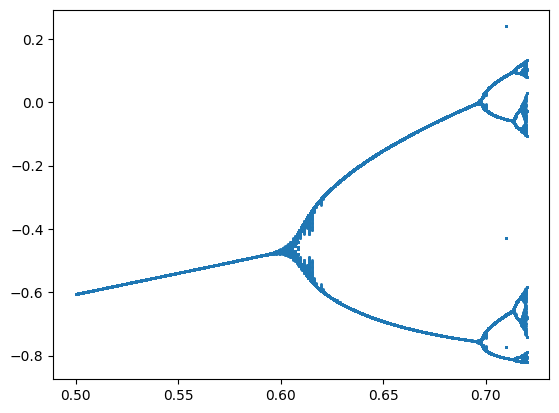

In [173]:
plt.scatter(A_list_x, maxima_y, s=1)
# plt.xlim(0.64, 0.72)
# plt.ylim(-0.50, -0.3)
plt.show()